In [41]:
# Step 1: Load the Oxford Flowers 102 dataset and filter to include only 5 selected classes
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load Oxford Flowers 102 dataset
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Define the selected classes
selected_classes = [7, 55, 48, 60, 5]  # Bird of Paradise, Water Lily, Osteospermum, Lotus, Tiger Lily

# Map class indices to flower names
flower_names = {
    7: "Bird of Paradise",
    55: "Water Lily",
    48: "Oxeye Daisy",
    60: "Lotus",
    5: "Tiger Lily"
}

# Filter dataset to keep only selected classes
def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, selected_classes))

ds_train = ds_train.filter(filter_classes)
ds_test = ds_test.filter(filter_classes)

# Preprocess images and remap labels to range 0-4 for the 5 selected classes
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Resize and normalize
    label = tf.where(tf.equal(label, selected_classes))[0][0]  # Map labels to 0-4
    return image, label

ds_train = ds_train.map(preprocess_image).batch(64).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image).batch(64).prefetch(tf.data.AUTOTUNE)

print("Dataset loaded and filtered to include 5 selected classes.")

# Count the number of images per class in the training and test sets
train_class_count = {i: 0 for i in range(5)}  # 5 classes
test_class_count = {i: 0 for i in range(5)}  # 5 classes

# Count images in the training set
for _, label in ds_train.unbatch():
    train_class_count[label.numpy()] += 1

# Count images in the test set
for _, label in ds_test.unbatch():
    test_class_count[label.numpy()] += 1

print("Number of images per class in the training set:", train_class_count)
print("Number of images per class in the test set:", test_class_count)

# Step 2: Balance the test set by limiting each class to 25 images

# Function to limit images per class (e.g., 25 images per class) without NumPy conversions
def limit_class_images(dataset, max_images_per_class=25):
    class_count = {i: 0 for i in range(5)}  # For 5 classes
    balanced_dataset = []

    # Iterate over the dataset and limit images per class
    for image, label in dataset.unbatch():
        label_val = label.numpy()
        if class_count[label_val] < max_images_per_class:
            balanced_dataset.append((image, label))
            class_count[label_val] += 1
        # Stop when all classes have reached the limit
        if all(count >= max_images_per_class for count in class_count.values()):
            break

    # Create a new balanced TensorFlow dataset from the filtered data
    images, labels = zip(*balanced_dataset)  # Separate images and labels
    balanced_dataset = tf.data.Dataset.from_tensor_slices((list(images), list(labels))).batch(64)
    return balanced_dataset

# Apply the function to limit the number of images per class in the test set
ds_test_balanced = limit_class_images(ds_test, max_images_per_class=25)

# Step 3: Count the new number of images per class after balancing the test set
test_class_count_balanced = {i: 0 for i in range(5)}  # For 5 classes

# Count images in the balanced test set
for _, label in ds_test_balanced.unbatch():
    test_class_count_balanced[label.numpy()] += 1

print("Number of images per class in the balanced test set:", test_class_count_balanced)

# Step 4: Proceed with model training or evaluation
# For example, this balanced test set can be used to evaluate the model after training


Dataset loaded and filtered to include 5 selected classes.
Number of images per class in the training set: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10}
Number of images per class in the test set: {0: 65, 1: 89, 2: 29, 3: 30, 4: 25}
Number of images per class in the balanced test set: {0: 25, 1: 25, 2: 25, 3: 25, 4: 25}



Displaying one image from each of the 5 selected classes:


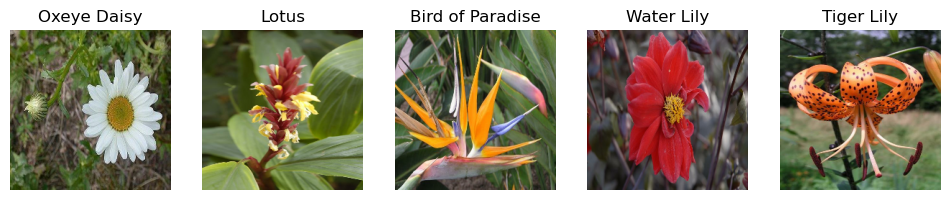

Here are 5 distinct flowers from the selected classes:
Oxeye Daisy
Lotus
Bird of Paradise
Water Lily
Tiger Lily


In [8]:
# Step 2: Display one image per class to visualize the dataset
print("\nDisplaying one image from each of the 5 selected classes:")

images_collected = {}
for image, label in ds_train.unbatch():
    label = label.numpy()
    if label not in images_collected:
        images_collected[label] = image
    if len(images_collected) == len(selected_classes):
        break  # Stop once we have one image from each class

# Display each image with its corresponding label
plt.figure(figsize=(12, 8))
for i, label in enumerate(images_collected):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_collected[label])
    plt.title(flower_names[selected_classes[label]])  # Display flower name
    plt.axis('off')
plt.show()

print("Here are 5 distinct flowers from the selected classes:")
for label in images_collected:
    print(f"{flower_names[selected_classes[label]]}")


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.2000 - loss: 1.6776 - val_accuracy: 0.3487 - val_loss: 1.5570
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4400 - loss: 1.5362 - val_accuracy: 0.3613 - val_loss: 1.4860
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4600 - loss: 1.4635 - val_accuracy: 0.4874 - val_loss: 1.4151
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6000 - loss: 1.3938 - val_accuracy: 0.6471 - val_loss: 1.3373
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.7600 - loss: 1.3210 - val_accuracy: 0.7731 - val_loss: 1.2574
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.8600 - loss: 1.2465 - val_accuracy: 0.8655 - val_loss: 1.1813
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9200 - loss: 1.1714 - val_accuracy: 0.9076 - val_loss: 1.1138
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9800 - loss: 1.0975 - val_accuracy: 0.9286 - val_loss: 1.0550


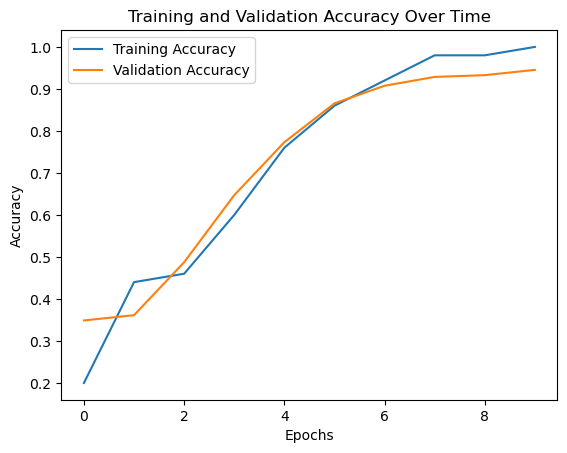

In [9]:
# Step 3: Build and train the model using VGG16 as the base
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Build model using VGG16 base
vgg16_base = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg16_base.trainable = False  # Freeze VGG16 layers

model = Sequential([
    vgg16_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')  # 5 classes (0-4 for the selected flowers)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=10)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Model Accuracy on Balanced Test Set: 93.60%


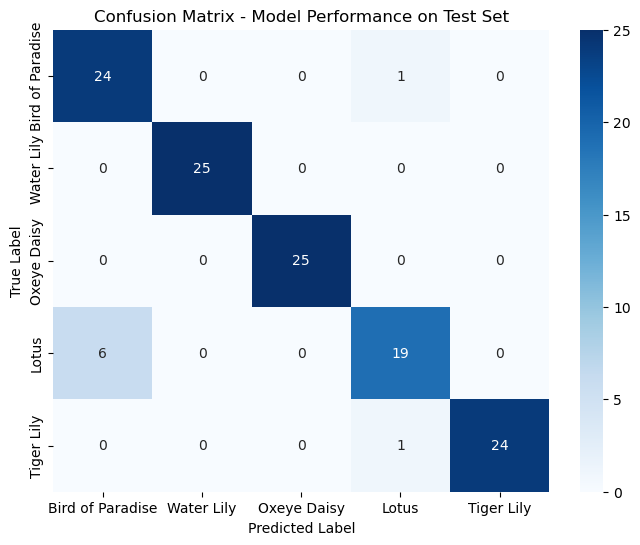

In [45]:
# Step 4: Evaluate initial performance and print confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Get predictions on the balanced test set
y_true = []
y_pred = []
for images, labels in ds_test_balanced.unbatch().batch(64):
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate model accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Accuracy on Balanced Test Set: {accuracy * 100:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=flower_names.values(), yticklabels=flower_names.values())
plt.title('Confusion Matrix - Model Performance on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


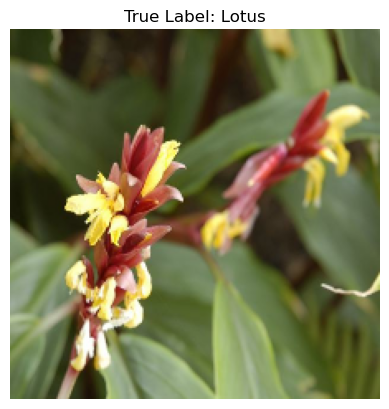

HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

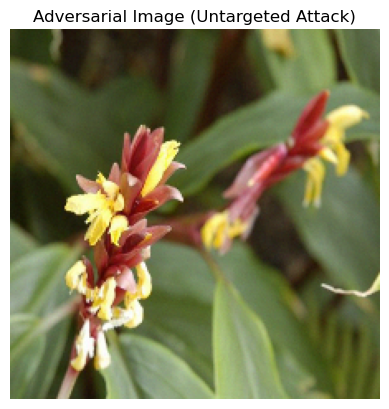

Prediction before attack: Lotus
Prediction after attack: Oxeye Daisy


In [29]:
# Step 5: Perform untargeted HopSkipJump attack
from art.attacks.evasion import HopSkipJump
from art.estimators.classification import TensorFlowV2Classifier

# Wrap the model using ART's TensorFlowV2Classifier
classifier = TensorFlowV2Classifier(model=model, input_shape=(224, 224, 3), nb_classes=5, clip_values=(0.0, 1.0))

# Get a sample image from the test set
for x_sample, y_sample in ds_test.take(8):
    x_sample = x_sample[:1]  # Take one image
    y_sample = y_sample[:1]  # Take its corresponding label

# Convert the TensorFlow tensor to a NumPy array
x_sample_np = x_sample.numpy()  # Convert to NumPy array

# Display the sample image and its true label
plt.imshow(x_sample_np.reshape(224, 224, 3))
plt.title(f"True Label: {flower_names[selected_classes[y_sample.numpy()[0]]]}")  # Display correct label
plt.axis('off')
plt.show()

# Perform untargeted HopSkipJump attack
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=10)
x_adv = attack.generate(x=x_sample_np)  # Pass NumPy array to the attack

# Display the adversarial image
plt.imshow(x_adv.reshape(224, 224, 3))
plt.title("Adversarial Image (Untargeted Attack)")
plt.axis('off')
plt.show()

# Check model predictions before and after the attack
pred_before = np.argmax(classifier.predict(x_sample_np), axis=1)
pred_after = np.argmax(classifier.predict(x_adv), axis=1)

print(f"Prediction before attack: {flower_names[selected_classes[pred_before[0]]]}")  # Prediction before attack
print(f"Prediction after attack: {flower_names[selected_classes[pred_after[0]]]}")   # Prediction after attack



HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

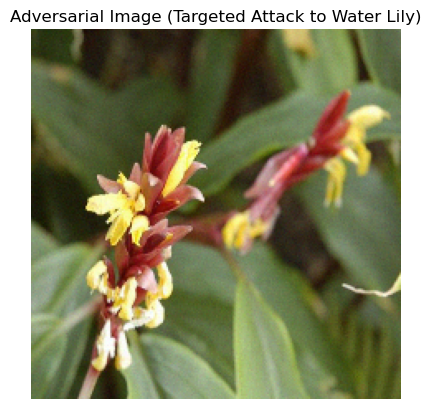

Prediction after targeted attack: Water Lily (Target: Water Lily)


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

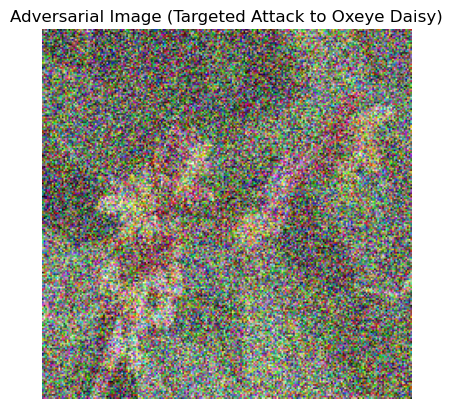

Prediction after targeted attack: Oxeye Daisy (Target: Oxeye Daisy)


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

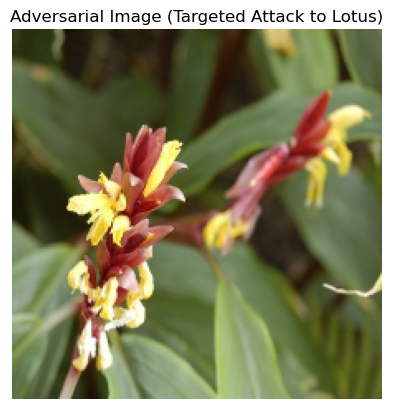

Prediction after targeted attack: Lotus (Target: Lotus)


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

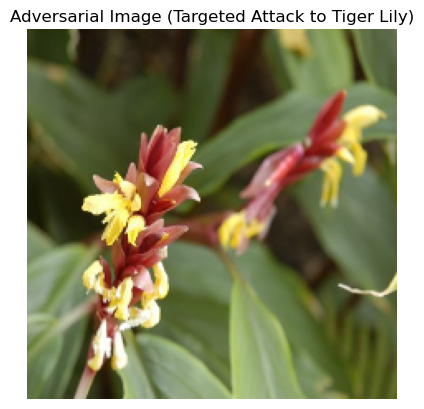

Prediction after targeted attack: Lotus (Target: Tiger Lily)


In [46]:
# Step 6: Perform a targeted HopSkipJump attack (misclassify into each of the other 4 classes)
# Set the available classes except the true one (we are assuming the sample is from class 0: Bird of Paradise)
target_classes = [1, 2, 3, 4]  # The other 4 classes (Water Lily, Oxeye Daisy, Lotus, Tiger Lily)

# Loop through each target class and perform a targeted HopSkipJump attack
for target_class_idx in target_classes:
    # Set up the target class for the attack
    target_class = np.array([target_class_idx])  # Target class index (e.g., 1 for Water Lily)
    target_class_one_hot = tf.keras.utils.to_categorical(target_class, num_classes=5)

    # Perform the targeted attack
    attack = HopSkipJump(classifier=classifier, targeted=True, max_iter=10)
    x_adv_targeted = attack.generate(x=x_sample_np, y=target_class_one_hot)

    # Display the adversarial image
    plt.imshow(x_adv_targeted.reshape(224, 224, 3))
    plt.title(f"Adversarial Image (Targeted Attack to {flower_names[selected_classes[target_class_idx]]})")
    plt.axis('off')
    plt.show()

    # Check model prediction after the targeted attack
    pred_after_targeted = np.argmax(classifier.predict(x_adv_targeted), axis=1)

    print(f"Prediction after targeted attack: {flower_names[selected_classes[pred_after_targeted[0]]]} (Target: {flower_names[selected_classes[target_class_idx]]})")


In [33]:
# Step 7: Compare predictions before and after both untargeted and targeted attacks
print(f"Untargeted Attack Results:")
print(f"Before attack: {flower_names[selected_classes[pred_before[0]]]}")
print(f"After untargeted attack: {flower_names[selected_classes[pred_after[0]]]}")

print("\nTargeted Attack Results:")
print(f"Before attack: {flower_names[selected_classes[pred_before[0]]]}")
print(f"After targeted attack: {flower_names[selected_classes[pred_after_targeted[0]]]} (Target: Bird of Paradise)")


Untargeted Attack Results:
Before attack: Lotus
After untargeted attack: Oxeye Daisy

Targeted Attack Results:
Before attack: Lotus
After targeted attack: Bird of Paradise (Target: Bird of Paradise)


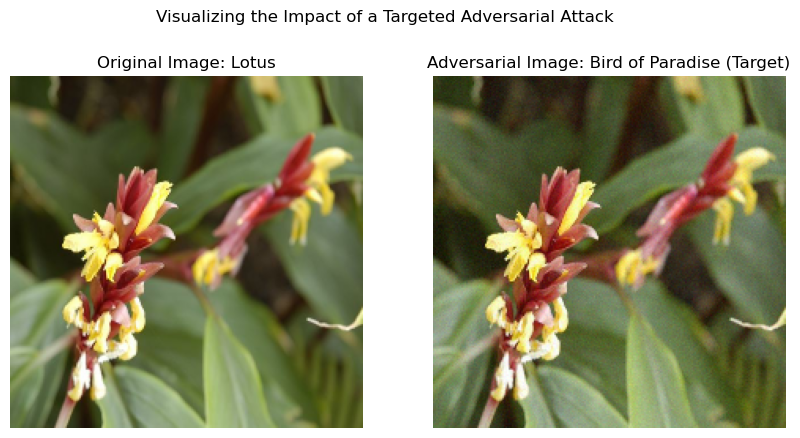

In [35]:
# Step 8: Final insights and visual comparison of original and adversarial images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_sample_np.reshape(224, 224, 3))
plt.title(f"Original Image: {flower_names[selected_classes[pred_before[0]]]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_adv_targeted.reshape(224, 224, 3))
plt.title(f"Adversarial Image: {flower_names[selected_classes[pred_after_targeted[0]]]} (Target)")
plt.axis('off')

plt.suptitle("Visualizing the Impact of a Targeted Adversarial Attack")
plt.show()
